# Import Libraries

In [1]:
# To handle data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To split train/test sets
from sklearn.model_selection import train_test_split

# To model
from sklearn.ensemble import RandomForestClassifier

# To measure model's performance
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data

In [2]:
application_records = pd.read_csv('application_record.csv', index_col = 'ID')
print(application_records.shape)
application_records.head(3)

(438557, 17)


CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
ID                                                                          
5008804          427500.0          Working               Higher education   
5008805          427500.0          Working               Higher education   
5008806          112500.0          Working  Secondary / secondary special   

        NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                         
5008804     Civil marriage   Rented apartment      -12005          -4542   
5008805     Civil marriage   Rented apartment      -12005          -4542   
5008806            Married  House / apartment      -21474          -1134   

         FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                             
5008804           1                1           0           0             NaN   
5008805           1                1           0           0             NaN   
5008806           1                0           0           0  Security staff   

         CNT_FAM_MEMBERS  
ID                        
5008804              2.0  
5008805              2.0  
5008806              2.0

In [3]:
credit_card = pd.read_csv('credit_Record.csv')
print(credit_card.shape)
credit_card.head(3)

(1048575, 3)


ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0

* **Status:**
    * **X**: No loan for the month
    * **C:** paid off that month
    * **0**: 1-29 days past due
    * **1**: 30-59 days past due
    * **2**: 60-89 days past due
    * **3**: 90-119 days past due
    * **4**: 120-149 days past due
    * **5**: 150++ days past due
* **Months_Balance:**
    * 0 = current month
    * -1 = previous month

In [4]:
# Encode status to '1' if client had a delay on payment and '0' if not
d_status = {'X':-1, 'C':-1}
credit_card.STATUS = credit_card.STATUS.replace(d_status).astype(int)
credit_card.STATUS = np.where(credit_card.STATUS>=0, 1, 0)
credit_card.STATUS.value_counts()

0    651261
1    397314
Name: STATUS, dtype: int64

### On average, does the client has a delay on payment?
This could indicate if the client is a high/low risk client

In [5]:
# First, on average, is the client's payment delayed? => probability that a "1" will be observed
prob_past = credit_card.groupby('ID').mean()[['STATUS']]

# Then cast to '0' and '1' if probability is above/below 0.5
p_dict = {key:(1 if value > 0.5 else 0) for key,value in zip(prob_past.index, prob_past.values)}
p_df = pd.DataFrame(p_dict.values(), index=p_dict.keys(), columns = ['HighRisk'])
p_df.HighRisk.value_counts()

0    26109
1    19876
Name: HighRisk, dtype: int64

In [6]:
months = credit_card.groupby('ID').count()['MONTHS_BALANCE']
p_df['MonthsBank'] = months
p_df.head()

HighRisk  MonthsBank
5001711         1           4
5001712         1          19
5001713         0          22
5001714         0          15
5001715         0          60

## Preprocessing

In [7]:
df = application_records.join(p_df, how='inner')
print(df.shape)
df.head()

(36457, 19)


CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
5008804   Rented apartment      -12005          -4542           1   
5008805   Rented apartment      -12005          -4542           1   
5008806  House / apartment      -21474          -1134           1   
5008808  House / apartment      -19110          -3051           1   
5008809  House / apartment      -19110          -3051           1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   

         CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804              2.0         0          16  
5008805              2.0         0          15  
5008806              2.0         0          30  
5008808              1.0         0           5  
5008809              1.0         0           5

In [8]:
df.FLAG_MOBIL.value_counts()

1    36457
Name: FLAG_MOBIL, dtype: int64

In [9]:
# Remove "empty" feature
df = df.drop(['FLAG_MOBIL'], axis = 1)

#### Gender, Car, Properties

In [10]:
# Mapping cat features
gender = {'M':0, 'F':1}
df.CODE_GENDER = df.CODE_GENDER.replace(gender)

y_n = {'Y':1, 'N':0}
df.FLAG_OWN_CAR = df.FLAG_OWN_CAR.replace(y_n)
df.FLAG_OWN_REALTY = df.FLAG_OWN_REALTY.replace(y_n)

df = df.rename(columns={'CODE_GENDER':'Female', 
                       'FLAG_OWN_CAR':'HasCar',
                       'FLAG_OWN_REALTY':'HasProperty'})

df.head(3)

Female  HasCar  HasProperty  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5008804       0       1            1             0          427500.0   
5008805       0       1            1             0          427500.0   
5008806       0       1            1             0          112500.0   

        NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
5008804          Working               Higher education     Civil marriage   
5008805          Working               Higher education     Civil marriage   
5008806          Working  Secondary / secondary special            Married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_WORK_PHONE  \
5008804   Rented apartment      -12005          -4542                1   
5008805   Rented apartment      -12005          -4542                1   
5008806  House / apartment      -21474          -1134                0   

         FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  HighRisk  \
5008804           0           0             NaN              2.0         0   
5008805           0           0             NaN              2.0         0   
5008806           0           0  Security staff              2.0         0   

         MonthsBank  
5008804          16  
5008805          15  
5008806          30

#### Age & Employment

In [11]:
# Days birth to Age
df.DAYS_BIRTH = round(np.abs(df.DAYS_BIRTH)/365).astype(int)

# Days employed as years employed
df.DAYS_EMPLOYED = round((np.abs(df.DAYS_EMPLOYED)+1)/365).astype(int)
df = df.rename(columns={'DAYS_BIRTH':'Age',
                        'DAYS_EMPLOYED':'YearsEmployed'})

# Transforming values meaning person unemployed 
df.YearsEmployed = df.YearsEmployed.mask(df.YearsEmployed > 1000, 0)

# Quick look
df.head(3)

Female  HasCar  HasProperty  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5008804       0       1            1             0          427500.0   
5008805       0       1            1             0          427500.0   
5008806       0       1            1             0          112500.0   

        NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  \
5008804          Working               Higher education     Civil marriage   
5008805          Working               Higher education     Civil marriage   
5008806          Working  Secondary / secondary special            Married   

         NAME_HOUSING_TYPE  Age  YearsEmployed  FLAG_WORK_PHONE  FLAG_PHONE  \
5008804   Rented apartment   33             12                1           0   
5008805   Rented apartment   33             12                1           0   
5008806  House / apartment   59              3                0           0   

         FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804           0             NaN              2.0         0          16  
5008805           0             NaN              2.0         0          15  
5008806           0  Security staff              2.0         0          30

#### Family status

In [12]:
df.NAME_FAMILY_STATUS.value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

In [13]:
marriage = {'Married':1, 'Civil marriage':1,
           'Single / not married':0, 'Separated':0, 'Widow':0}

df.NAME_FAMILY_STATUS = df.NAME_FAMILY_STATUS.replace(marriage)
df = df.rename(columns={'NAME_FAMILY_STATUS':'Married'})
df.head(3)

Female  HasCar  HasProperty  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5008804       0       1            1             0          427500.0   
5008805       0       1            1             0          427500.0   
5008806       0       1            1             0          112500.0   

        NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  Married  \
5008804          Working               Higher education        1   
5008805          Working               Higher education        1   
5008806          Working  Secondary / secondary special        1   

         NAME_HOUSING_TYPE  Age  YearsEmployed  FLAG_WORK_PHONE  FLAG_PHONE  \
5008804   Rented apartment   33             12                1           0   
5008805   Rented apartment   33             12                1           0   
5008806  House / apartment   59              3                0           0   

         FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804           0             NaN              2.0         0          16  
5008805           0             NaN              2.0         0          15  
5008806           0  Security staff              2.0         0          30

### Education

In [14]:
educ = {'Higher education':1, 'Academic degree':1,
        'Secondary / secondary special':0, 'Incomplete higher':0, 'Lower secondary':0}
df.NAME_EDUCATION_TYPE= df.NAME_EDUCATION_TYPE.replace(educ)

df = df.rename(columns={'NAME_EDUCATION_TYPE':'HigherEd'})
df.head(3)

Female  HasCar  HasProperty  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5008804       0       1            1             0          427500.0   
5008805       0       1            1             0          427500.0   
5008806       0       1            1             0          112500.0   

        NAME_INCOME_TYPE  HigherEd  Married  NAME_HOUSING_TYPE  Age  \
5008804          Working         1        1   Rented apartment   33   
5008805          Working         1        1   Rented apartment   33   
5008806          Working         0        1  House / apartment   59   

         YearsEmployed  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
5008804             12                1           0           0   
5008805             12                1           0           0   
5008806              3                0           0           0   

        OCCUPATION_TYPE  CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804             NaN              2.0         0          16  
5008805             NaN              2.0         0          15  
5008806  Security staff              2.0         0          30

### Housing

In [15]:
housing = {'House / apartment':1,
           'With parents':0, 'Municipal apartment':0, 'Rented apartment':0,
           'Office apartment':0, 'Co-op apartment':0}
df.NAME_HOUSING_TYPE = df.NAME_HOUSING_TYPE.replace(housing)
df = df.rename(columns={'NAME_HOUSING_TYPE':'HouseAptmt'})
df.head(3)

Female  HasCar  HasProperty  CNT_CHILDREN  AMT_INCOME_TOTAL  \
5008804       0       1            1             0          427500.0   
5008805       0       1            1             0          427500.0   
5008806       0       1            1             0          112500.0   

        NAME_INCOME_TYPE  HigherEd  Married  HouseAptmt  Age  YearsEmployed  \
5008804          Working         1        1           0   33             12   
5008805          Working         1        1           0   33             12   
5008806          Working         0        1           1   59              3   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   

         CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804              2.0         0          16  
5008805              2.0         0          15  
5008806              2.0         0          30

### Children

In [16]:
df['CNT_CHILDREN'] = np.where(df.CNT_CHILDREN>0, 1, 0)
df = df.rename(columns={'CNT_CHILDREN':'HasChildren'})
df.HasChildren.value_counts()
df.head(3)

Female  HasCar  HasProperty  HasChildren  AMT_INCOME_TOTAL  \
5008804       0       1            1            0          427500.0   
5008805       0       1            1            0          427500.0   
5008806       0       1            1            0          112500.0   

        NAME_INCOME_TYPE  HigherEd  Married  HouseAptmt  Age  YearsEmployed  \
5008804          Working         1        1           0   33             12   
5008805          Working         1        1           0   33             12   
5008806          Working         0        1           1   59              3   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   

         CNT_FAM_MEMBERS  HighRisk  MonthsBank  
5008804              2.0         0          16  
5008805              2.0         0          15  
5008806              2.0         0          30

### Occupation

In [17]:
df.OCCUPATION_TYPE = df.OCCUPATION_TYPE.fillna('Unknown')

In [18]:
# from feature_engine.encoding import CountFrequencyEncoder

# enc = CountFrequencyEncoder(variables = ['OCCUPATION_TYPE'])
# enc.fit(df)
# df = enc.transform(df)

#### Average profile of HighRisk/LowRisk clients

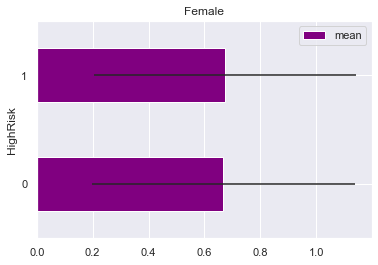

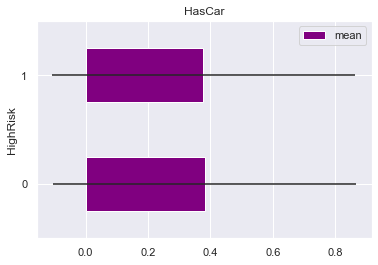

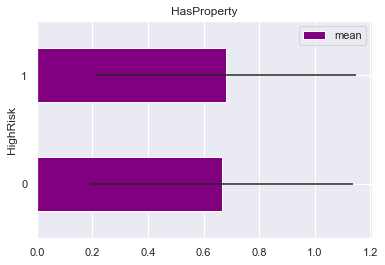

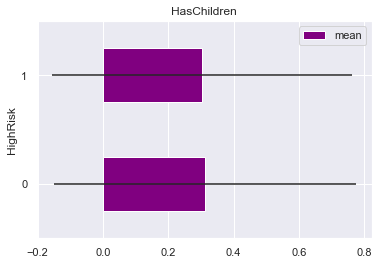

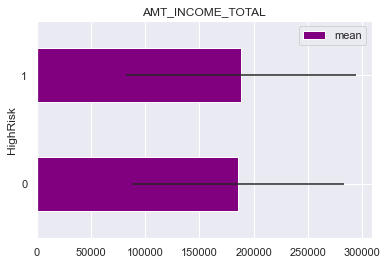

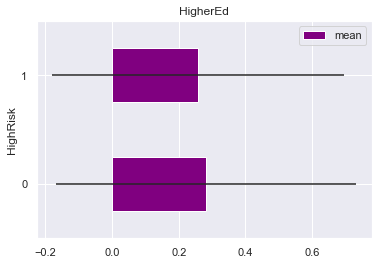

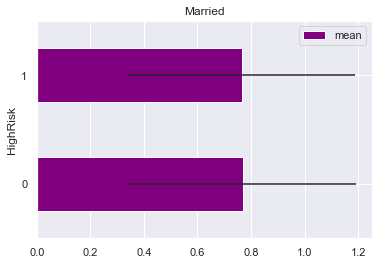

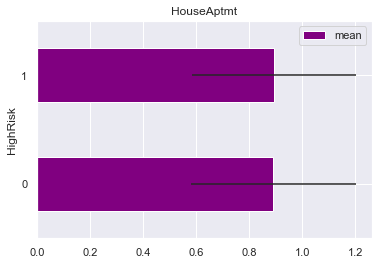

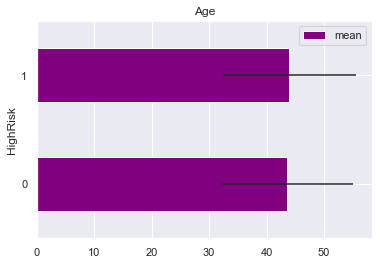

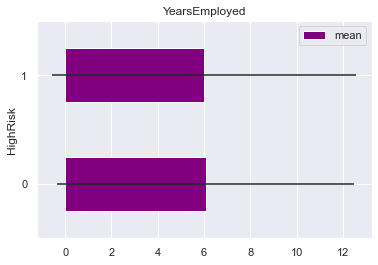

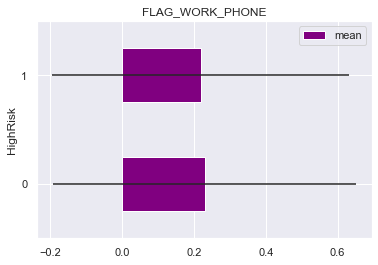

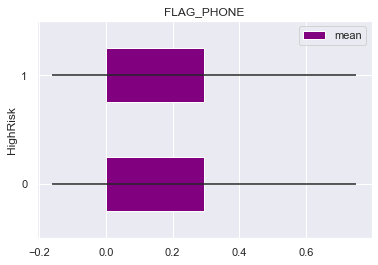

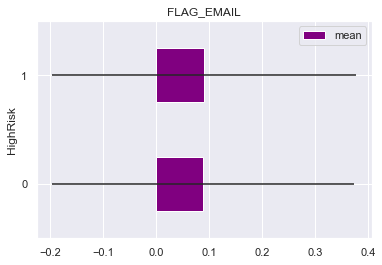

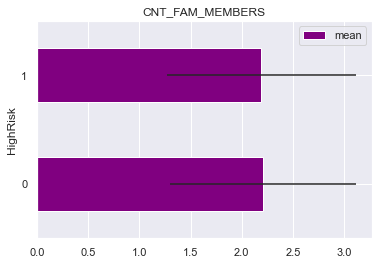

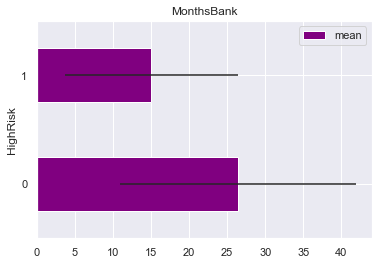

In [19]:
num_vars = [var for var in df if (df[var].dtype != 'O') & (var != 'HighRisk')]

tmp = df.groupby(['HighRisk']).agg(['mean', 'std'])

for var in num_vars:
    tmp[var].plot(kind='barh', xerr='std',
                 title=var, color='purple')

In [20]:
df.NAME_INCOME_TYPE

5008804                 Working
5008805                 Working
5008806                 Working
5008808    Commercial associate
5008809    Commercial associate
                   ...         
5150482                 Working
5150483                 Working
5150484                 Working
5150485                 Working
5150487                 Working
Name: NAME_INCOME_TYPE, Length: 36457, dtype: object

In [21]:
df = df.rename(columns={'AMT_INCOME_TOTAL':'AnnualIncome',
                        'NAME_INCOME_TYPE':'IncomeCat',
                        'FLAG_WORK_PHONE':'HasWorkPhone',
                        'FLAG_PHONE':'HasPhone',
                        'FLAG_EMAIL':'HasEmail',
                        'OCCUPATION_TYPE':'Occupation',
                        'CNT_FAM_MEMBERS':'FamilySize'})
df.head(3)

Female  HasCar  HasProperty  HasChildren  AnnualIncome IncomeCat  \
5008804       0       1            1            0      427500.0   Working   
5008805       0       1            1            0      427500.0   Working   
5008806       0       1            1            0      112500.0   Working   

         HigherEd  Married  HouseAptmt  Age  YearsEmployed  HasWorkPhone  \
5008804         1        1           0   33             12             1   
5008805         1        1           0   33             12             1   
5008806         0        1           1   59              3             0   

         HasPhone  HasEmail      Occupation  FamilySize  HighRisk  MonthsBank  
5008804         0         0         Unknown         2.0         0          16  
5008805         0         0         Unknown         2.0         0          15  
5008806         0         0  Security staff         2.0         0          30

# Modeling

In [22]:
# Encode categorical features
data = pd.get_dummies(df)
data.shape

(36457, 40)

In [23]:
train, test = train_test_split(data, test_size = 0.15, random_state = 42) 

# Training data
X_train = train.drop(['HighRisk'], axis = 1)
y_train = train[['HighRisk']]

# Test data
X_test = test.drop(['HighRisk'], axis = 1)
y_test = test[['HighRisk']]

# Quick look at training features
X_train.head()

Female  HasCar  HasProperty  HasChildren  AnnualIncome  HigherEd  \
5038865       0       1            1            1      270000.0         0   
5126724       1       0            1            1      112500.0         0   
5126029       1       1            1            0      108000.0         0   
5100367       1       0            1            1       72000.0         0   
5091120       0       0            1            1      292500.0         0   

         Married  HouseAptmt  Age  YearsEmployed  ...  \
5038865        1           1   40              4  ...   
5126724        1           1   37              7  ...   
5126029        0           1   47              3  ...   
5100367        1           0   54              6  ...   
5091120        1           1   41              8  ...   

         Occupation_Low-skill Laborers  Occupation_Managers  \
5038865                              0                    0   
5126724                              0                    0   
5126029                              0                    0   
5100367                              0                    0   
5091120                              0                    0   

         Occupation_Medicine staff  Occupation_Private service staff  \
5038865                          0                                 0   
5126724                          0                                 0   
5126029                          0                                 0   
5100367                          0                                 0   
5091120                          0                                 0   

         Occupation_Realty agents  Occupation_Sales staff  \
5038865                         0                       0   
5126724                         0                       1   
5126029                         0                       0   
5100367                         0                       0   
5091120                         0                       0   

         Occupation_Secretaries  Occupation_Security staff  \
5038865                       0                          0   
5126724                       0                          0   
5126029                       0                          0   
5100367                       0                          0   
5091120                       0                          0   

         Occupation_Unknown  Occupation_Waiters/barmen staff  
5038865                   0                                0  
5126724                   0                                0  
5126029                   0                                0  
5100367                   0                                0  
5091120                   0                                0  

[5 rows x 39 columns]

In [24]:
%%time
model = RandomForestClassifier(random_state=42, max_depth=20, max_features=5)

model.fit(X_train, y_train.values.ravel())
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Wall time: 3.32 s


In [25]:
print('- train:')
print('    f1_score:', round(f1_score(y_train, y_pred_train),3))
print('- test:')
print('    f1_score:', round(f1_score(y_test, y_pred_test),3))

- train:
    f1_score: 0.898
- test:
    f1_score: 0.711


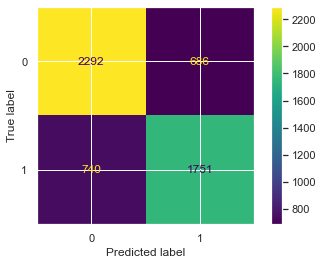

In [26]:
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot();

# Explaining Model

In [27]:
feat_imp = pd.DataFrame(model.feature_importances_, 
                        index=X_train.columns, 
                        columns=['FeatureImportance'])

feat_imp.sort_values(by='FeatureImportance', ascending=False).head(7)

FeatureImportance
MonthsBank              0.435316
Age                     0.101281
AnnualIncome            0.099802
YearsEmployed           0.072596
FamilySize              0.030189
HasCar                  0.019230
HasPhone                0.018640

In [28]:
# Create a dictionary to easily access features indices
feat_names = {name:index for (index, name) in enumerate(X_train.columns)}

==============================================================
# Global Model-Agnostic Methods

## Partial Dependence Plots

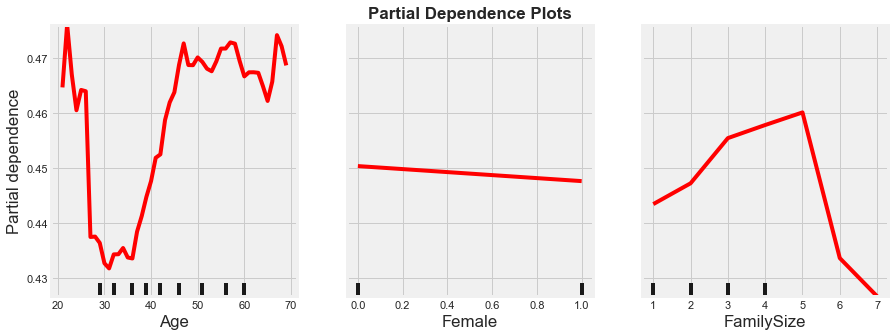

In [29]:
# Import Library
from sklearn.inspection import PartialDependenceDisplay

# Choose features: Kms & Years
f1, f2, f3 = feat_names.get('Age'), feat_names.get('Female'), feat_names.get('FamilySize')

# Display the PDP
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Partial Dependence Plots', weight='bold', size=17)

with plt.style.context('fivethirtyeight'):
    PartialDependenceDisplay.from_estimator(model, 
                                            X_test, 
                                            features=[f1,f2,f3], 
                                            kind='average',
                                            random_state=42,
                                            line_kw={'color':'red'},
                                            ax=ax)
plt.show()

# ALE

In [30]:
# Fitting the model without feature names
model_ = RandomForestClassifier(random_state = 42)

X_train_ = X_train.values
X_test_ = X_test.values

model_.fit(X_train_, y_train.values.ravel())

RandomForestClassifier(random_state=42)

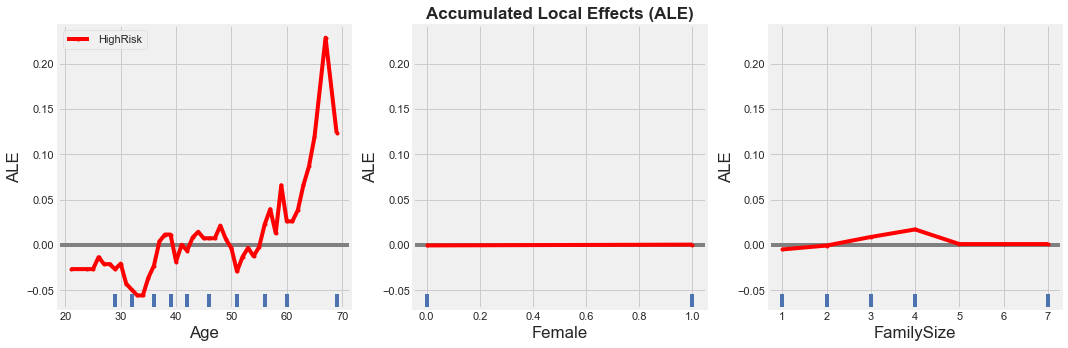

In [31]:
# Import libraries
from alibi.explainers import ALE, plot_ale

# Get ALE
ale = ALE(model_.predict, feature_names=X_test.columns, target_names=['HighRisk'])
exp = ale.explain(X_test_, features = [f1,f2,f3])

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Accumulated Local Effects (ALE)', weight='bold', size=17)

with plt.style.context('fivethirtyeight'):
    plot_ale(exp, line_kw={'color':'red'}, ax=ax)
plt.show()

## Permutation Feature Importance

In [32]:
# Required library
from sklearn.inspection import permutation_importance

# Getting permutation importance
r = permutation_importance(model, X_test, y_test,
                           random_state=7)

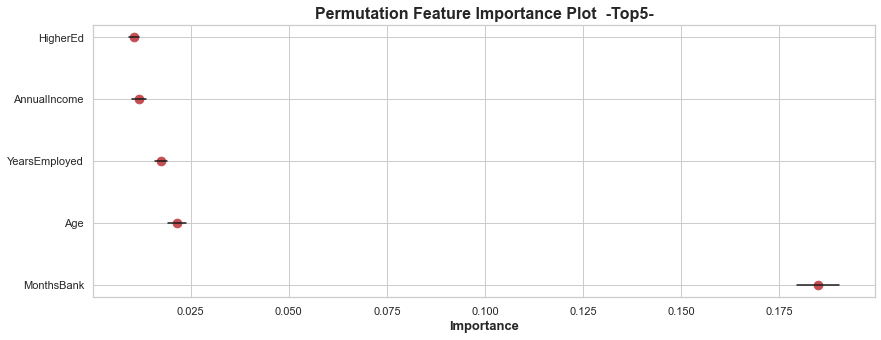

In [33]:
features_names = []
importance = []
lower, upper = [], []

for i in r.importances_mean.argsort()[::-1]:
    features_names.append(X_test.columns[i])
    importance.append(r.importances_mean[i])
    lower.append(r.importances_mean[i] - r.importances_std[i]) 
    upper.append(r.importances_mean[i] + r.importances_std[i]) 

# Selecting 5 most important features
importance_top5 = importance[:5]    
features_names_top5 = features_names[:5]    
lower_top5, uppper_top5 = lower[:5], upper[:5]

with sns.axes_style("whitegrid"):
    yaxis = range(len(importance_top5))

    # Plotting the avg importances
    plt.figure(figsize = (14,5))
    plt.scatter(importance_top5, yaxis, color = 'r', s=75)

    # plotting std importances 
    plt.plot((lower_top5, uppper_top5), (yaxis, yaxis), 'k-')
        
    # y ticks
    plt.yticks([i for i, _ in enumerate(features_names_top5)], features_names_top5)

    # other parameters
    plt.xlabel('Importance', weight ='bold', size = 13)
    plt.title('Permutation Feature Importance Plot  -Top5-', weight = 'bold', size = 16)

    plt.show()

=======================
# Local Model-Agnostic Methods

### Scoped Rules (Anchors)

In [35]:
# Import library
from anchor import anchor_tabular

# Call explainer
explainer = anchor_tabular.AnchorTabularExplainer(
    ["Low Risk", "High Risk"],
    X_train.columns,
    X_train_)

# Get a local prediction
idx = 42
np.random.seed(42)
print('Prediction: ', explainer.class_names[model_.predict(X_test_[idx].reshape(1, -1))[0]])
exp = explainer.explain_instance(X_test_[idx], model_.predict, threshold=0.95)
exp.show_in_notebook()

Prediction:  Low Risk


## LIME

Intercept 0.39823463316188323
Prediction_local [0.66085765]
Right: 0.8795833333333334
Real value: 1


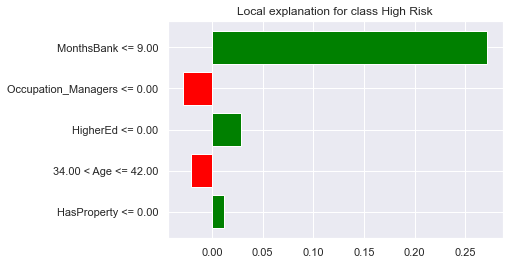

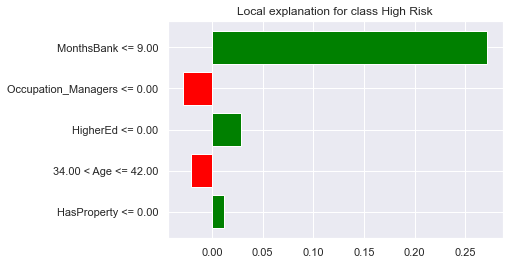

In [36]:
# Import library
from lime.lime_tabular import LimeTabularExplainer


# Explainer
explainer = LimeTabularExplainer(X_test_, 
                                   feature_names=X_test.columns, 
                                   class_names=['Low Risk','High Risk'], 
                                   verbose=True, 
                                   mode='classification')

# Local Instance
idx = 150
exp = explainer.explain_instance(X_test_[idx], model_.predict_proba, num_features=5)
print('Real value:', y_test.values[idx][0])
exp.as_pyplot_figure()

In [37]:
exp.show_in_notebook(show_table=True)

## SHAP

100%|===================| 10924/10938 [11:31<00:00]        

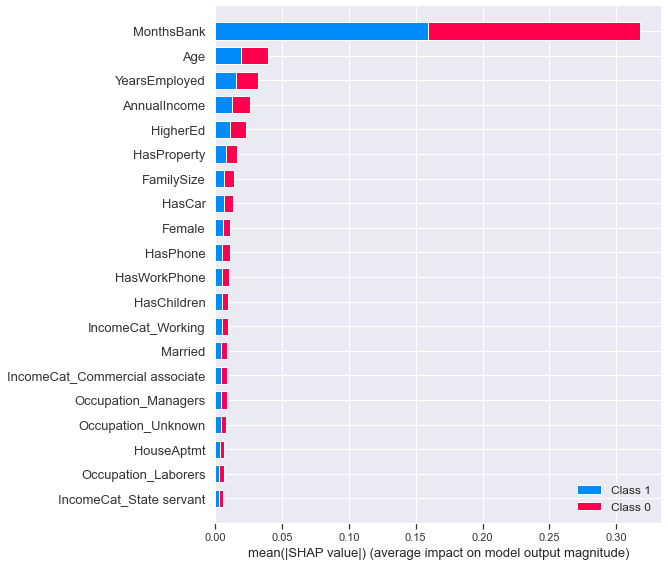

In [39]:
# Import library
import shap

# SHAP Explainer
explainer = shap.TreeExplainer(model, X_train, feature_dependence='feature_perturbation')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [61]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_test.iloc[idx,:])

In [46]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_test.iloc[:1000,:])